In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Cargado de Mapas de los lagos Steffen y Martin

In [3]:
from Genetico.config import ruta_mapas 

datos = []

# Leer cada archivo con rasterio
for mapa in ruta_mapas:
    with rasterio.open(mapa) as src:
        # Leer los datos como una matriz de numpy
        data = src.read(1)  # Leer la primera banda (asumiendo datos en una banda)
        datos.append(data)
        ny = src.height # Nro de filas
        nx = src.width # Nro de columnas

# Tamaño de cada celda
d = 30 # metros

vientod = np.flipud(datos[0])
vientov = np.flipud(datos[1])
pendiente = np.flipud(datos[2])
vegetacion = np.flipud(datos[3])
orientacion = np.flipud(datos[4])

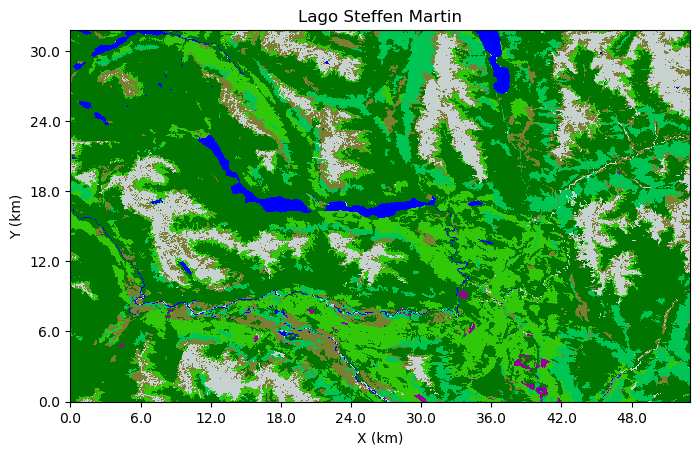

In [4]:
# Definir los nuevos colores para los valores del archivo (0 a 7)
vegetation_colors = np.array([
    [255, 0, 255],      # 0: NODATA (magenta)
    [199, 209, 207],    # 1: Sin combustible (gris claro)
    [0, 0, 255],        # 2: Lagos (azul)
    [0, 117, 0],        # 3: Bosque A (verde oscuro)
    [50, 200, 10],      # 4: Bosque B (verde brillante)
    [150, 0, 150],      # 5: Bosque I (morado)
    [122, 127, 50],     # 6: Pastizal (verde oliva)
    [0, 196, 83]        # 7: Arbustal (verde intenso)
]) / 255.0  # Escalar los valores RGB al rango [0, 1]

# Mapear los valores de vegetación a colores RGB
vegetation = vegetation_colors[vegetacion.astype(int)]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(vegetation, interpolation='nearest', origin='lower')
x_ticks = np.arange(0, nx, 200)  # Cada 200 celdas en el eje X
y_ticks = np.arange(0, ny, 200)  # Cada 200 celdas en el eje Y
x_labels = (x_ticks * d) / 1000  # Convertir a kilómetros
y_labels = (y_ticks * d) / 1000
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels([f"{x:.1f}" for x in x_labels])  # Formato con 1 decimal
ax.set_yticklabels([f"{y:.1f}" for y in y_labels])  # Formato con 1 decimal
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
plt.title('Lago Steffen Martin')
# plt.savefig('grilla_nuevos_colores.png', dpi=300, bbox_inches='tight')

# ax.scatter([699], [727], color='red', marker='*', s=100, edgecolors='black', label='Foco del incendio')

# plt.xlim(650, 800)    
# plt.ylim(680, 770)

plt.show()

## Incendio de referencia

## Visualización de Vectores de Viento

In [5]:
# Convertir dirección del viento (grados) a componentes vectoriales
# Nota: En meteorología, la dirección del viento indica DE DÓNDE viene el viento
# Por ejemplo, 90° significa viento del Este (viene del Este, va hacia el Oeste)

# Convertir grados a radianes
viento_rad = np.deg2rad(vientod)

# Calcular componentes vectoriales del viento
# Componente U (Este-Oeste): positivo hacia el Este
# Componente V (Norte-Sur): positivo hacia el Norte
# Invertimos las componentes porque la dirección indica DE DÓNDE viene el viento
wx = -vientov * np.sin(viento_rad)  # Componente Este-Oeste
wy = -vientov * np.cos(viento_rad)  # Componente Norte-Sur

print(f"Dimensiones del dominio: {ny} x {nx} celdas")
print(f"Resolución espacial: {d} metros por celda")
print(f"Velocidad del viento - Min: {vientov.min():.2f}, Max: {vientov.max():.2f} m/s")
print(f"Dirección del viento - Min: {vientod.min():.1f}°, Max: {vientod.max():.1f}°")
print(f"Componente wx - Min: {wx.min():.2f}, Max: {wx.max():.2f} m/s")
print(f"Componente wy - Min: {wy.min():.2f}, Max: {wy.max():.2f} m/s")

Dimensiones del dominio: 1060 x 1768 celdas
Resolución espacial: 30 metros por celda
Velocidad del viento - Min: 0.07, Max: 143.38 m/s
Dirección del viento - Min: 0.0°, Max: 360.0°
Componente wx - Min: -80.90, Max: 126.43 m/s
Componente wy - Min: -129.22, Max: 77.35 m/s


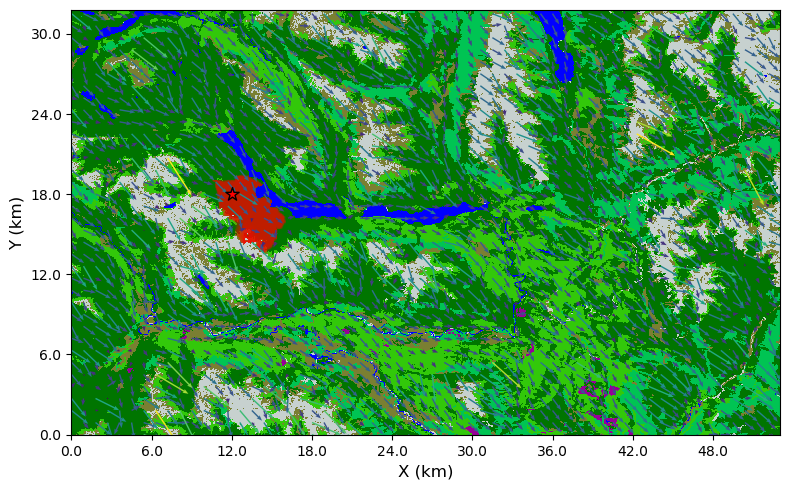

In [6]:
R_np = np.squeeze(np.load("R_referencia_1.npy"))

# R_np = np.load("R_final.npy")[1]

# Crear visualización de vectores de viento sobre el mapa de vegetación
fig, ax = plt.subplots(figsize=(8, 8))

# Mostrar el mapa de vegetación como fondo
terrain_rgb = (1 - np.clip(R_np[..., None], 0, 1)) * vegetation + np.clip(R_np[..., None], 0, 1) * np.array([1.0, 0.0, 0.0])
im = ax.imshow(terrain_rgb, interpolation='nearest', origin='lower')

# Configurar el espaciado para los vectores (reducir densidad para mejor visualización)
step = 30  # Mostrar un vector cada 30 celdas
y_coords, x_coords = np.meshgrid(
    np.arange(0, ny, step), 
    np.arange(0, nx, step), 
    indexing='ij'
)

# Submuestrear los datos de viento
wx_sub = wx[::step, ::step]
wy_sub = wy[::step, ::step]
vientov_sub = vientov[::step, ::step]

# Crear el plot de vectores (quiver)
# Usamos la velocidad para colorear los vectores
quiver = ax.quiver(x_coords, y_coords, wx_sub, wy_sub, 
                   vientov_sub, 
                   cmap='viridis', 
                   scale=1,  # Reducir aún más el scale para hacer vectores más largos
                   scale_units='xy',
                   angles='xy',
                   alpha=1,
                   width=0.002,  # Aumentar más el grosor de los vectores
                   headwidth=3,  # Aumentar el tamaño de las cabezas de flecha
                   headlength=4,  # Aumentar la longitud de las cabezas de flecha
                   headaxislength=3.5)  # Ajustar la longitud del eje de la cabeza

# Configurar ejes y etiquetas
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels([f"{x:.1f}" for x in x_labels])
ax.set_yticklabels([f"{y:.1f}" for y in y_labels])
ax.set_xlabel("X (km)", fontsize=12)
ax.set_ylabel("Y (km)", fontsize=12)
# ax.set_title('Vectores de Viento sobre Mapa de Vegetación\nLagos Steffen y Martin', fontsize=14)

# Agregar una leyenda de escala para los vectores
# Crear un vector de referencia
ref_speed = 10  # m/s
ax.quiverkey(quiver, 0.85, 0.95, ref_speed, f'{ref_speed} m/s', 
             labelpos='E', coordinates='figure', fontproperties={'size': 10})

ax.scatter([400], [600], color='red', marker='*', s=100, edgecolors='black', label='Foco del incendio')

# plt.xlim(500, 700)    
# plt.ylim(200, 400)

plt.tight_layout()
plt.show()

In [96]:
# Encuentra las posiciones donde R_np > 0 (celdas quemadas)
indices_quemadas = np.where(R_np > 0)

# Obtiene los valores de vegetación en esas posiciones
tipos_vegetacion_quemada = vegetacion[indices_quemadas]

# Imprime los tipos de vegetación presentes en las celdas quemadas (sin repetir)
tipos, counts = np.unique(tipos_vegetacion_quemada, return_counts=True)
proporciones = counts / counts.sum()
print("Tipos de vegetación en celdas quemadas:", tipos)
print("Proporciones de cada tipo:", proporciones*100)

Tipos de vegetación en celdas quemadas: [3. 4. 5. 6. 7.]
Proporciones de cada tipo: [29.38447852 44.51728374  3.53300008 12.75523172  9.81000593]


In [67]:
# Filtrar vegetación para considerar solo valores >= 3
mask = vegetacion >= 3
tipos, counts = np.unique(vegetacion[mask], return_counts=True)
proporciones = counts / counts.sum()
print("Tipos de vegetación", tipos)
print("Proporciones de cada tipo: ", proporciones*100)

Tipos de vegetación [3. 4. 5. 6. 7.]
Proporciones de cada tipo:  [56.25138375 20.26555576  0.3041002  11.04097736 12.13798292]


## Mapa de Alturas

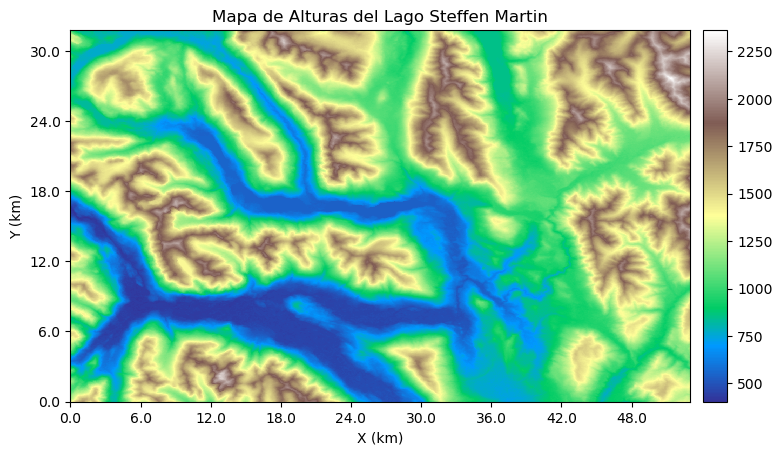

In [9]:
ruta_mapa_altura = r'c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/mapas_steffen_martin/asc_DEM.asc'

with rasterio.open(ruta_mapa_altura) as src:
    # Leer los datos como una matriz de numpy
    mapa_altura = src.read(1)  # Leer la primera banda (asumiendo datos en una banda)
    ny = src.height # Nro de filas
    nx = src.width # Nro de columnas

mapa_altura = np.flipud(mapa_altura)  # Invertir el mapa verticalmente para que coincida con origin='lower'

# Mostrar el mapa de alturas
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mapa_altura, cmap='terrain', interpolation='nearest', origin='lower')
x_ticks = np.arange(0, nx, 200)  # Cada 200 celdas en el eje X
y_ticks = np.arange(0, ny, 200)  # Cada 200 celdas en el eje Y
x_labels = (x_ticks * d) / 1000  # Convertir a kilómetros
y_labels = (y_ticks * d) / 1000
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels([f"{x:.1f}" for x in x_labels])
ax.set_yticklabels([f"{y:.1f}" for y in y_labels])
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
plt.title('Mapa de Alturas del Lago Steffen Martin')

# Agregar barra de color con la misma altura que el eje
cax = inset_axes(ax,
                 width="4%",       # ancho relativo
                 height="100%",    # altura igual al eje
                 loc='lower left', # ubicación relativa
                 bbox_to_anchor=(1.02, 0., 1, 1),  # x, y, ancho, alto relativos al ax
                 bbox_transform=ax.transAxes,
                 borderpad=0)

cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)


## Área quemada (incendio real)

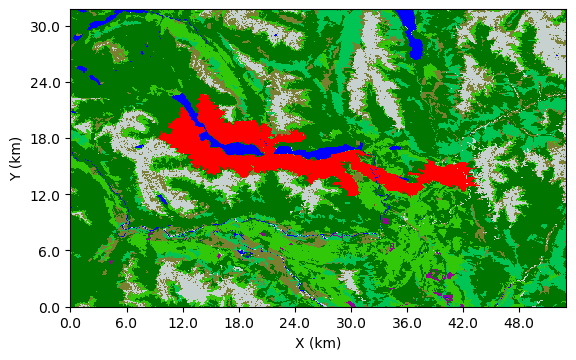

In [30]:
mapa_real = r'c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/mapas_steffen_martin/area_quemada_SM.asc'

with rasterio.open(mapa_real) as src:
    # Leer los datos como una matriz de numpy
    area_quemada = src.read(1)  # Leer la primera banda (asumiendo datos en una banda)
    ny = src.height # Nro de filas
    nx = src.width # Nro de columnas

area_quemada = np.flipud(area_quemada)  # Invertir el mapa verticalmente para que coincida con origin='lower'

# Encuentra las posiciones donde R_np > 0 (celdas quemadas)
indices_quemadas = np.where(area_quemada > 0)
tipos_vegetacion_quemada = vegetacion[indices_quemadas]
# Filtrar las posiciones donde la vegetación es tipo 1 o 2 (no combustibles)
mask_combustible = ~np.isin(tipos_vegetacion_quemada, [1, 2])
tipos_vegetacion_quemada = tipos_vegetacion_quemada[mask_combustible]
indices_quemadas_filtrados = (indices_quemadas[0][mask_combustible], indices_quemadas[1][mask_combustible])

# Opcional: poner a cero el área quemada en esas posiciones no combustibles
area_quemada[indices_quemadas[0][~mask_combustible], indices_quemadas[1][~mask_combustible]] = 0

fig, ax1 = plt.subplots()

terrain_rgb = (1 - np.clip(area_quemada[..., None], 0, 1)) * vegetation + np.clip(area_quemada[..., None], 0, 1) * np.array([1.0, 0.0, 0.0])
im2 = ax1.imshow(terrain_rgb, interpolation='nearest', origin='lower')

# Aplicar los ticks y etiquetas a los ejes
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels([f"{x:.1f}" for x in x_labels])  # Formato con 2 decimales
ax1.set_yticklabels([f"{y:.1f}" for y in y_labels])  # Formato con 2 decimales

# Etiquetas de los ejes
ax1.set_xlabel("X (km)")
ax1.set_ylabel("Y (km)")

# ax1.scatter([400], [600], color='red', marker='*', s=100, edgecolors='black', label='Foco del incendio')

# plt.xlim(300, 720)
# plt.ylim(400, 800)
plt.show()

In [97]:
indices_quemadas = np.where(area_quemada > 0)
tipos_vegetacion_quemada = vegetacion[indices_quemadas]

# Imprime los tipos de vegetación presentes en las celdas quemadas (sin repetir)
tipos, counts = np.unique(tipos_vegetacion_quemada, return_counts=True)
proporciones = counts / counts.sum()
print("Tipos de vegetación en celdas quemadas:", tipos)
print("Proporciones de cada tipo:", proporciones*100)

Tipos de vegetación en celdas quemadas: [3. 4. 6. 7.]
Proporciones de cada tipo: [61.12873779 28.59864934  1.54829218  8.72432068]


## Mapas de Beta y Gamma

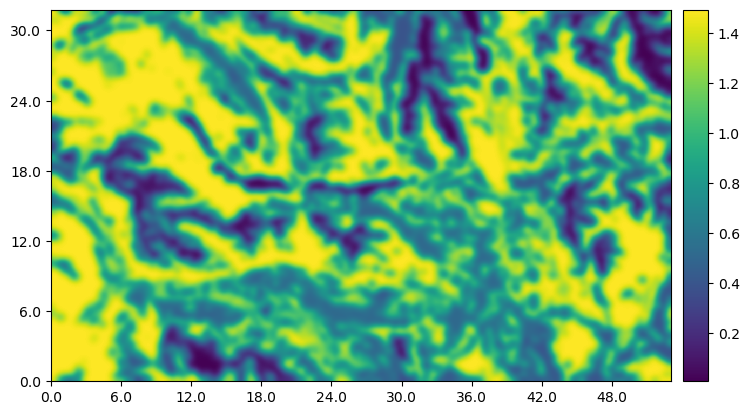

In [8]:
import scipy.ndimage

beta_map = np.load('beta_veg.npy')
beta_map = scipy.ndimage.gaussian_filter(beta_map, sigma=10.0)

# Crear visualización de vectores de viento sobre el mapa de vegetación
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(beta_map, interpolation='nearest', origin='lower')
x_ticks = np.arange(0, nx, 200)  # Cada 200 celdas en el eje X
y_ticks = np.arange(0, ny, 200)  # Cada 200 celdas en el eje Y
x_labels = (x_ticks * d) / 1000  # Convertir a kilómetros
y_labels = (y_ticks * d) / 1000 
ax.set_xticks(x_ticks) 
ax.set_yticks(y_ticks) 
ax.set_xticklabels([f"{x:.1f}" for x in x_labels]) 
ax.set_yticklabels([f"{y:.1f}" for y in y_labels]) 

# Agregar barra de color con la misma altura que el eje
cax = inset_axes(ax,
                 width="4%",       # ancho relativo
                 height="100%",    # altura igual al eje
                 loc='lower left', # ubicación relativa
                 bbox_to_anchor=(1.02, 0., 1, 1),  # x, y, ancho, alto relativos al ax
                 bbox_transform=ax.transAxes,
                 borderpad=0)

cbar = plt.colorbar(im, cax=cax)